# On commence d'abord par définir les foncitons que l'on va utiliser

In [1]:
import numpy as np # import du package 'numpy' avec alias 'np'
import PIL.Image as pim # import du module 'Image' du package 'Pillow' avec alias 'pim'
import matplotlib.pyplot as plt

def view(image, mode=None, clamp=None, file=None, scale=1):
    """Deffinition de la fonction qui permet d'afficher une image"""
    from IPython.display import display

    assert isinstance(image, (np.ndarray, pim.Image)), 'wrong data for image'
    assert isinstance(clamp, (type(None), tuple)), 'wrong range for clamping'
    if isinstance(image, pim.Image): 
        image = np.array(image.convert('RGB') if image.mode == 'P' else image)
    elif image.ndim == 3 and image.shape[2] == 1: 
        image = image[:, :, 0]  # convert to 'L' mode
    if not clamp: 
        hi = image.max()
        clamp = (0, hi if hi else 1)
    lo, hi = clamp
    image = (np.clip(image, lo, hi) - lo) / (hi - lo) * 255
    image = pim.fromarray(image.astype('u1'))
    if mode: 
        image = image.convert(mode)  # optional: convert image to provided 'mode'
    if scale != 1:
        width, height = image.size
        new_size = (int(width * scale), int(height * scale))
        image = image.resize(new_size, pim.Resampling.NEAREST)  # Resize with scaling
    if file: 
        image.save(file)  # optional: save image to provided 'file'
    display(image)

In [2]:
def formatter_image_NB(image):
    """
    permet de donner une image quelconque en entrée et qui est utilisable par la suite dans le programme
    l'image doit être carrée
    on remet l'image sur [-1, 1 -1 en blanc et 1 en noir
    """
    img = pim.open(image) # lecture de l'image
    W, _ = img.size
    N = W
    try:
        image = np.array(img)[:,:,0] # on récupère uniquement la composante Rouge (arbitraire)
    except:
        image = np.array(img) # Image is already grayscale, no need to index RGB channels

    image = image.astype(np.int16) # convertir en int16 pour que le programme accepte les nobre négatifs

    for i in range(N):
        for j in range(N):
            if image[i, j] > 200: 
                image[i, j] = 1
            else: 
                image[i, j] = -1

    return N, image


In [3]:
def generer_bruit(N, res, p):
    """
    Permet de générer du bruit
    Prendre des carrés de resxres pour bruiter l'image
    """
    bruit = np.ones((N, N))
    for i in range(0, N, res):
        for j in range(0, N, res):
            if np.random.rand() < p: 
                bruit[i:i+res, j:j+res] = -1 #la valeur du pixel change de manière aléatoire
    return bruit

In [4]:
def plot_final(image_initiale, image_bruitee, image_finale):
    """
    Permet d'afficher le plot final
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_initiale, cmap='gray')
    axs[0].set_title('sigma0 (image de base)')
    axs[1].imshow(image_bruitee, cmap='gray')
    axs[1].set_title('sigma (image bruitée)')
    axs[2].imshow(image_finale, cmap='gray')
    axs[2].set_title('S (image finale)')

    plt.show()

# Modèle d'Ising avec recuit simulé, et échantillonnage de Gibbs

/var/folders/st/mx912zyj291fqllt6m0_srgw0000gn/T/ipykernel_23345/3078681241.py:31: RuntimeWarning: overflow encountered in exp
  r = np.exp(-2 * Saux[k, l] * (2 * alpha * sigmaaux[k, l] + beta * s) / T) # probabilité de changer de signe (application de la formule de Metropolis)


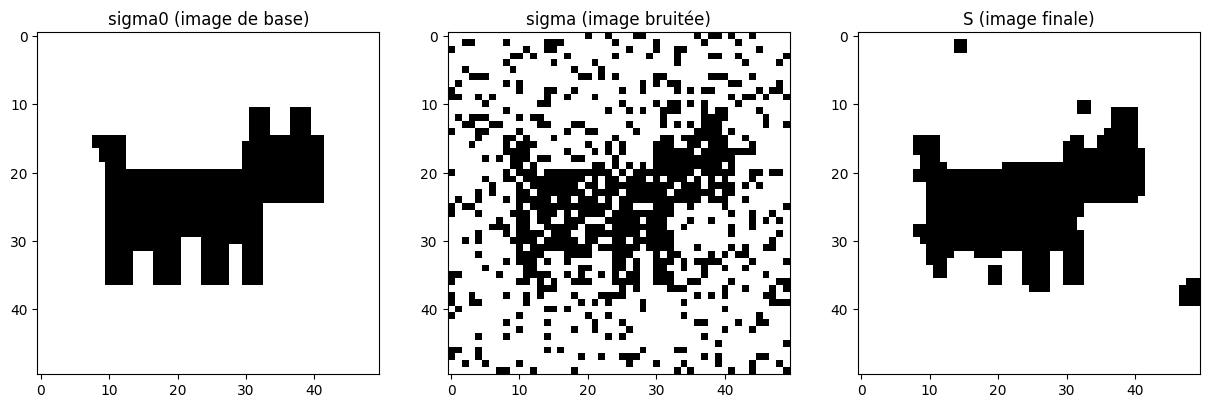

In [5]:
n = 100000 # nombre d'itérations
alpha = 1/3 # Plus alpha est grand, plus l'image est proche de l'image initiale
beta = 2/3 # Plus beta est grand, plus on a des contours nets, élimination du bruit
p = 0.2 # probabilité de bruit

# importation de l'image
N, sigma0 = formatter_image_NB('images/gatitoo.png')
#print(sigma0[30]) #vérification des pixels
#view(sigma0) #verification de l'image importée

# on génère notre bruit
bruit = generer_bruit(N, 1, p)
sigma = sigma0 * bruit # application du bruit

Saux = np.zeros((N+2, N+2)) # on rajoute des bords pour éviter les problèmes de voisins
Saux[1:N+1, 1:N+1] = sigma # on remplit la matrice auxiliaire avec sigma
sigmaaux = Saux.copy()

for q in range(1, n+1):
    #T = 1/np.log(1+q) # température (elle diminue pour atteindre la configuration stable)
    T = 1/q

    # coordonnées aléatoires tirées pour le site s
    k = np.random.randint(1, N+1)
    l = np.random.randint(1, N+1)

    s = Saux[k-1, l] + Saux[k+1, l] + Saux[k, l-1] + Saux[k, l+1] # somme des pixels voisins
    #s = Saux[k-1, l] + Saux[k+1, l] + Saux[k+1, l+1] + Saux[k+1, l-1] + Saux[k, l-1] + Saux[k, l+1] + Saux[k-1, l+1] + Saux[k-1, l-1] 
    #s = Saux[k-1, l] + Saux[k+1, l] + Saux[k+1, l+1] + Saux[k+1, l-1] + Saux[k, l-1] + Saux[k, l+1] + Saux[k-1, l+1] + Saux[k-1, l-1] + Saux[k, l-2] + Saux[k, l+2] + Saux[k-1, l-1] + Saux[k-2, l] + Saux[k+2, l]  

    r = np.exp(-2 * Saux[k, l] * (2 * alpha * sigmaaux[k, l] + beta * s) / T) # probabilité de changer de signe (application de la formule de Metropolis)
    
    if np.random.rand() < r: # on change de signe si la probabilité est inférieure à r
        Saux[k, l] = -Saux[k, l]

S = Saux[1:N+1, 1:N+1] # résultat final (on enlève les bords avant de l'afficher)
plot_final(sigma0, sigma, S)

# Visualistaion des pixels qui n'ont pas changé

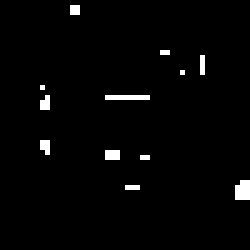

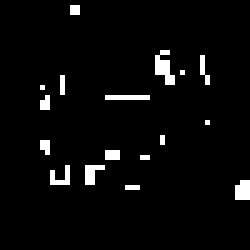

In [6]:
# on fait la vraie image - image finale
diff = sigma0 - S
view(diff, scale=5)

# pour obtenir les pixels qui ont changé
abs = np.abs(diff)//2
view(abs, scale=5)